In [266]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

%matplotlib inline

# Question

1.Build a model which is better than the bank model. For simplicity, assume that: If you grant the loan and the it doesn't get repaid, you lose 1
If you grant the loan and the it does get repaid, you gain 1
If you don't grant the loan, you gain 0

2.Using the rules above, compare bank profitability vs your model profitability

3.Describe the impact of the most important variables on the prediction. Also, focus on the variable "is_employed", which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? Explain why

4.Are there any other variables, not in the data provided, that you'd have liked to include in the model?

# Load Dataset

In [267]:
loan = pd.read_csv('/Users/check4068/Desktop/Product Sense/12.Loan granting/loan_table.csv', parse_dates=['date'])
loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [268]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   loan_id       101100 non-null  int64         
 1   loan_purpose  101100 non-null  object        
 2   date          101100 non-null  datetime64[ns]
 3   loan_granted  101100 non-null  int64         
 4   loan_repaid   47654 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.9+ MB


In [269]:
borrower = pd.read_csv('/Users/check4068/Desktop/Product Sense/12.Loan granting/borrower_table.csv')
borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [270]:
borrower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

# Data Processing

In [271]:
# merge loan and borrower information
data = pd.merge(left=loan, right=borrower, on='loan_id')

In [272]:
# choose data with loan granted 
# the data with loan not granted is not useful for profit calculation
data = data[data['loan_granted'] == 1]
data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4
6,780070,business,2012-03-14,1,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,303138,emergency_funds,2012-08-31,1,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,91475,investment,2012-05-25,1,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 3 to 101098
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   loan_id                                          47654 non-null  int64         
 1   loan_purpose                                     47654 non-null  object        
 2   date                                             47654 non-null  datetime64[ns]
 3   loan_granted                                     47654 non-null  int64         
 4   loan_repaid                                      47654 non-null  float64       
 5   is_first_loan                                    47654 non-null  int64         
 6   fully_repaid_previous_loans                      21865 non-null  float64       
 7   currently_repaying_other_loans                   21865 non-null  float64       
 8   total_credit_card_limit            

In [274]:
# check missing values
missing = data.isnull().sum()
missing[missing > 0]

fully_repaid_previous_loans                        25789
currently_repaying_other_loans                     25789
avg_percentage_credit_card_limit_used_last_year      903
dtype: int64

Now, after removing the data with `loan` not granted, our goal is to predict whether or not the user is going to repay the loan. 

In [275]:
# parse date information and extract month, week, and dayofweek information
data['month'] = data['date'].apply(lambda x: x.month)
data['week'] = data['date'].apply(lambda x: x.week)
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

# drop useless features
data = data.drop(labels=['loan_id', 'date', 'loan_granted'], axis=1, inplace=False)

# Visualization

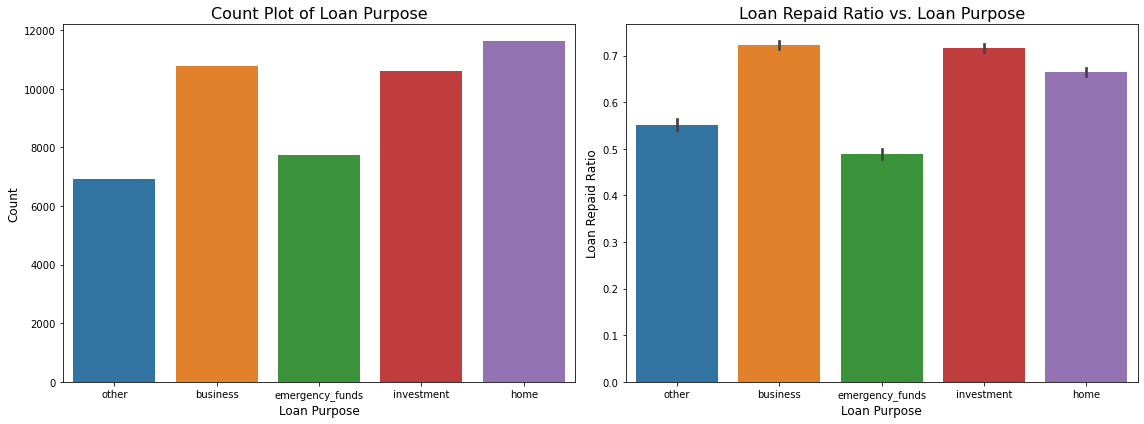

In [276]:
# visualization of 'loan_purpose'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='loan_purpose', data=data, ax=ax[0])
ax[0].set_xlabel('Loan Purpose', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Loan Purpose', fontsize=16)

sns.barplot(x='loan_purpose', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('Loan Purpose', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. Loan Purpose', fontsize=16)
plt.tight_layout()
plt.show()

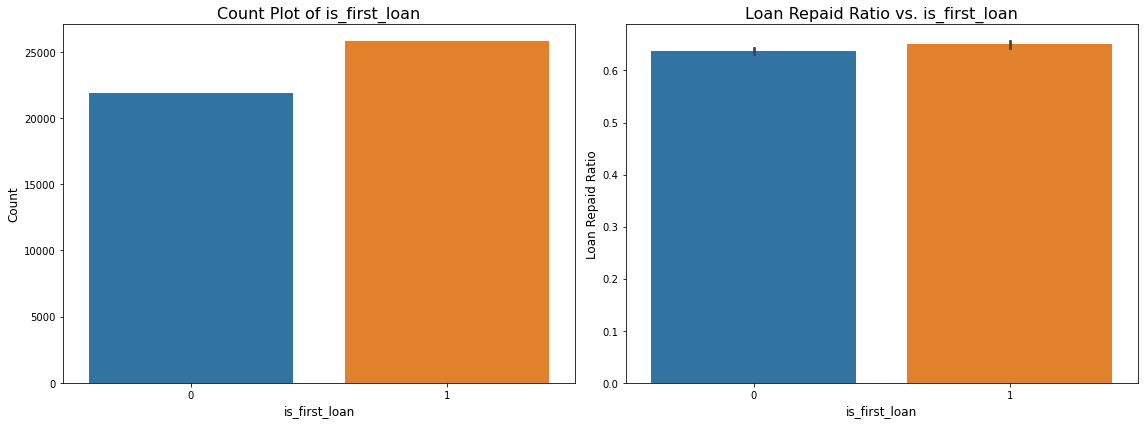

In [52]:
# visualization of 'is_first_loan'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='is_first_loan', data=data, ax=ax[0])
ax[0].set_xlabel('is_first_loan', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of is_first_loan', fontsize=16)

sns.barplot(x='is_first_loan', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('is_first_loan', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. is_first_loan', fontsize=16)
plt.tight_layout()
plt.show()

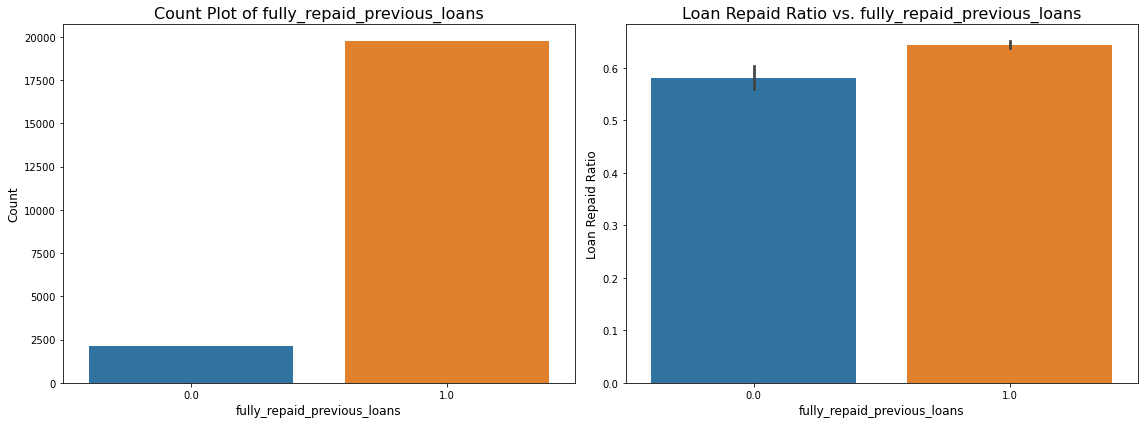

In [53]:
# visualization of 'fully_repaid_previous_loans'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='fully_repaid_previous_loans', data=data, ax=ax[0])
ax[0].set_xlabel('fully_repaid_previous_loans', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of fully_repaid_previous_loans', fontsize=16)

sns.barplot(x='fully_repaid_previous_loans', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('fully_repaid_previous_loans', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. fully_repaid_previous_loans', fontsize=16)
plt.tight_layout()
plt.show()

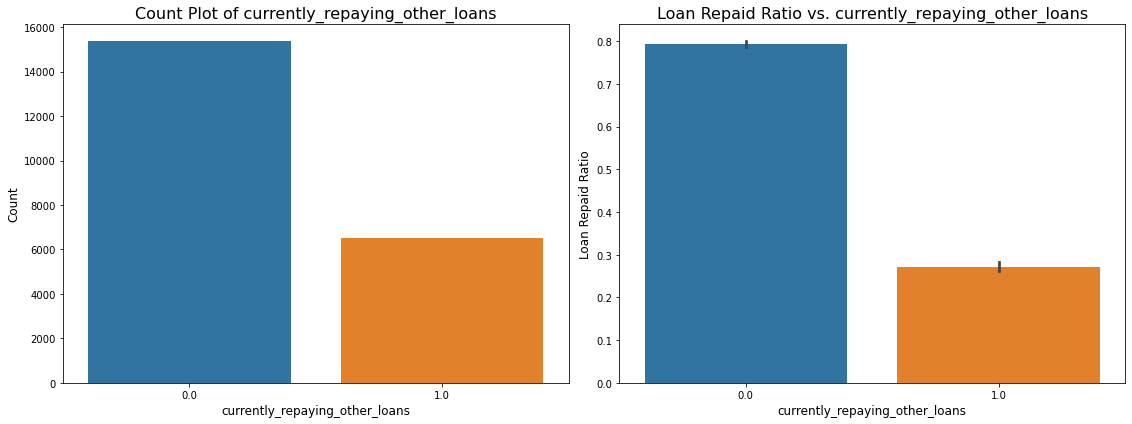

In [54]:
# visualization of 'currently_repaying_other_loans'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='currently_repaying_other_loans', data=data, ax=ax[0])
ax[0].set_xlabel('currently_repaying_other_loans', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of currently_repaying_other_loans', fontsize=16)

sns.barplot(x='currently_repaying_other_loans', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('currently_repaying_other_loans', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. currently_repaying_other_loans', fontsize=16)
plt.tight_layout()
plt.show()

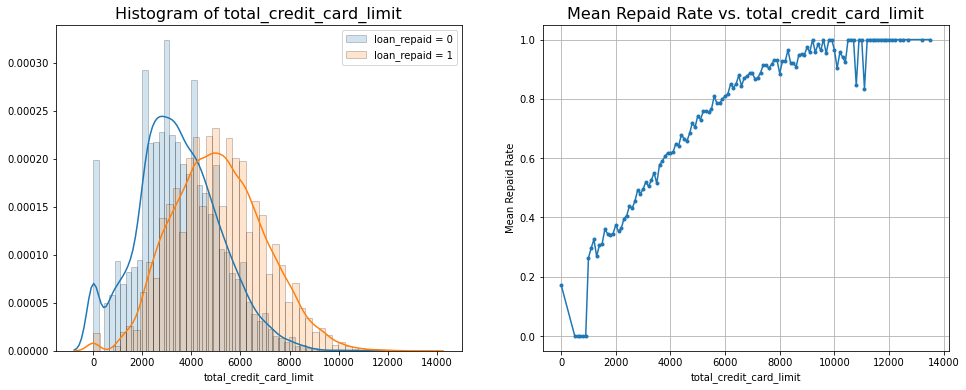

In [55]:
# Visualization of 'total_credit_card_limit'
grouped = data[['total_credit_card_limit', 'loan_repaid']].groupby('total_credit_card_limit')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['total_credit_card_limit'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['total_credit_card_limit'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of total_credit_card_limit', fontsize=16)
ax[0].legend()
ax[1].plot(mean['total_credit_card_limit'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. total_credit_card_limit', fontsize=16)
ax[1].set_xlabel('total_credit_card_limit')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

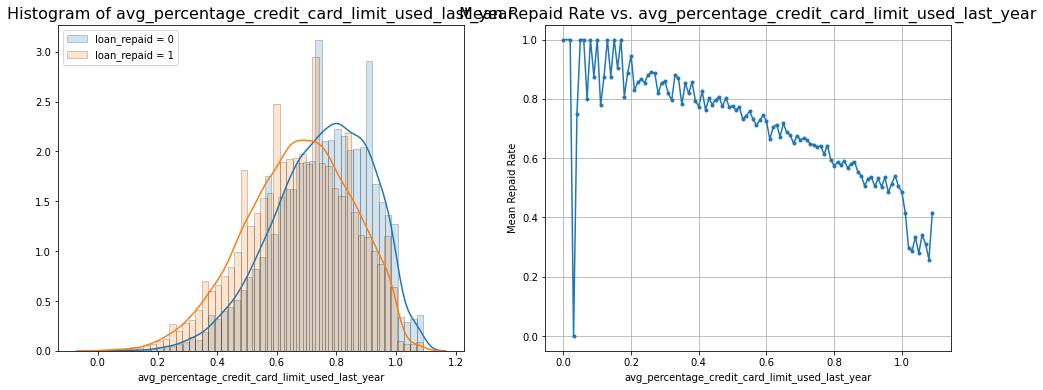

In [56]:
# Visualization of 'avg_percentage_credit_card_limit_used_last_year'
not_null = data[~data['avg_percentage_credit_card_limit_used_last_year'].isnull()]
grouped = not_null.groupby('avg_percentage_credit_card_limit_used_last_year')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(not_null[not_null['loan_repaid'] == 0]['avg_percentage_credit_card_limit_used_last_year'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(not_null[not_null['loan_repaid'] == 1]['avg_percentage_credit_card_limit_used_last_year'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of avg_percentage_credit_card_limit_used_last_year', fontsize=16)
ax[0].legend()
ax[1].plot(mean['avg_percentage_credit_card_limit_used_last_year'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. avg_percentage_credit_card_limit_used_last_year', fontsize=16)
ax[1].set_xlabel('avg_percentage_credit_card_limit_used_last_year')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

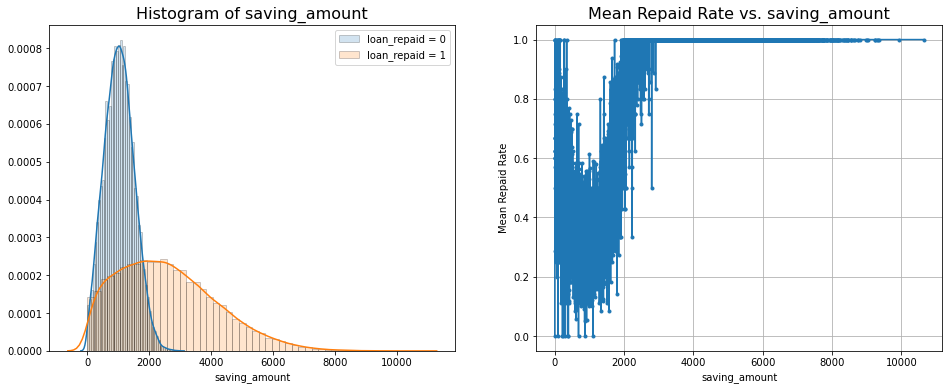

In [57]:
# Visualization of 'saving_amount'
grouped = data[['saving_amount', 'loan_repaid']].groupby('saving_amount')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['saving_amount'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['saving_amount'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of saving_amount', fontsize=16)
ax[0].legend()
ax[1].plot(mean['saving_amount'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. saving_amount', fontsize=16)
ax[1].set_xlabel('saving_amount')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

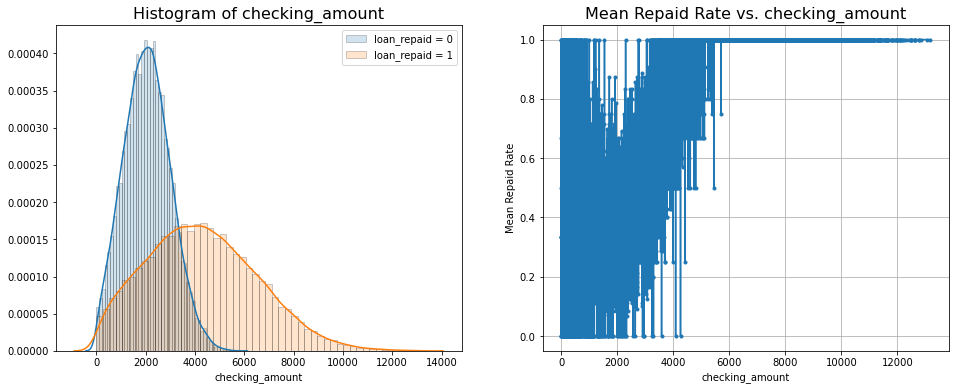

In [58]:
# Visualization of 'checking_amount'
grouped = data[['checking_amount', 'loan_repaid']].groupby('checking_amount')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['checking_amount'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['checking_amount'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of checking_amount', fontsize=16)
ax[0].legend()
ax[1].plot(mean['checking_amount'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. checking_amount', fontsize=16)
ax[1].set_xlabel('checking_amount')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

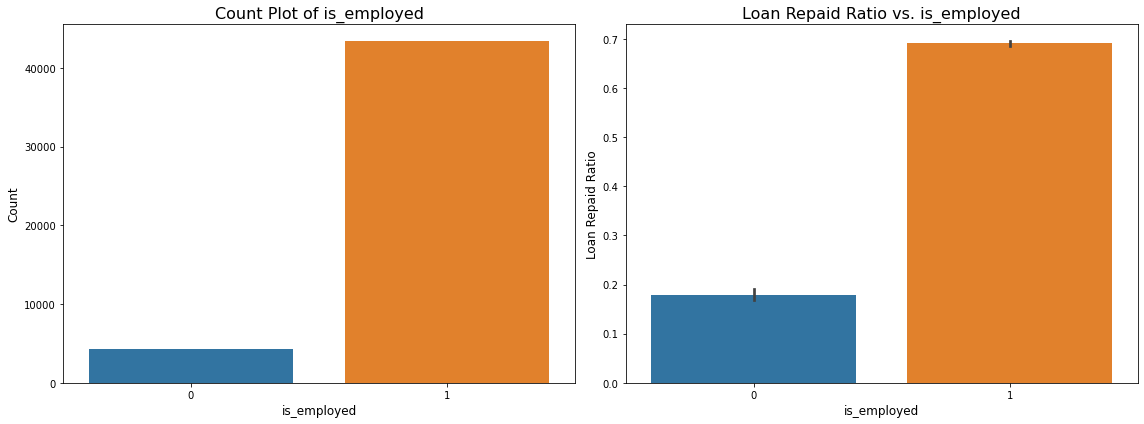

In [59]:
# visualization of 'is_employed'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='is_employed', data=data, ax=ax[0])
ax[0].set_xlabel('is_employed', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of is_employed', fontsize=16)

sns.barplot(x='is_employed', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('is_employed', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. is_employed', fontsize=16)
plt.tight_layout()
plt.show()

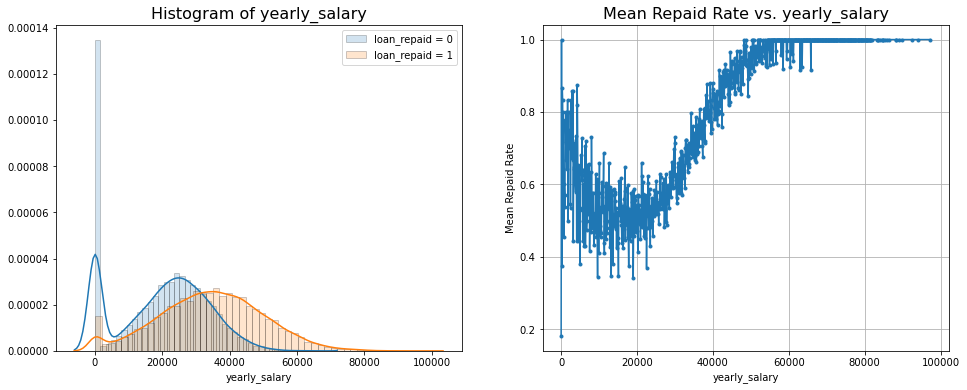

In [60]:
# Visualization of 'yearly_salary'
grouped = data[['yearly_salary', 'loan_repaid']].groupby('yearly_salary')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['yearly_salary'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['yearly_salary'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of yearly_salary', fontsize=16)
ax[0].legend()
ax[1].plot(mean['yearly_salary'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. yearly_salary', fontsize=16)
ax[1].set_xlabel('yearly_salary')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

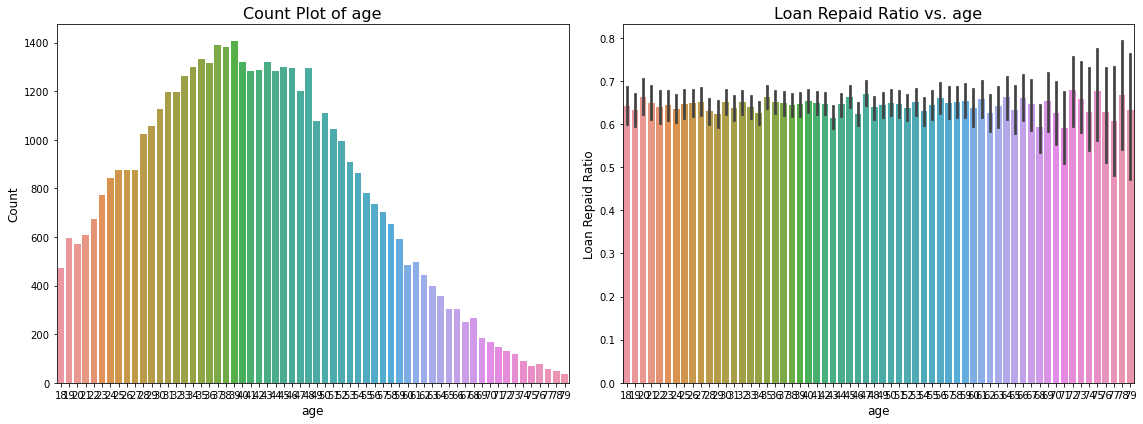

In [61]:
# visualization of 'age'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='age', data=data, ax=ax[0])
ax[0].set_xlabel('age', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of age', fontsize=16)

sns.barplot(x='age', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('age', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. age', fontsize=16)
plt.tight_layout()
plt.show()

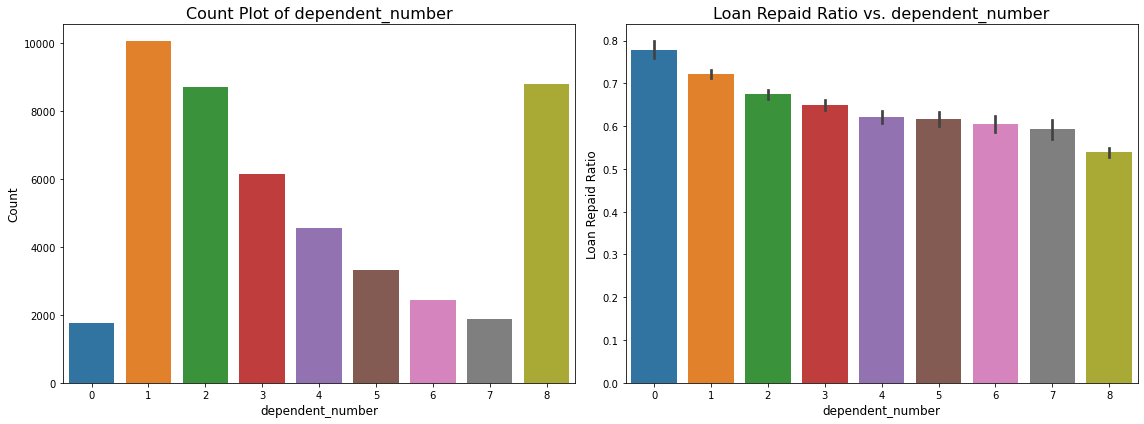

In [62]:
# visualization of 'age'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dependent_number', data=data, ax=ax[0])
ax[0].set_xlabel('dependent_number', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dependent_number', fontsize=16)

sns.barplot(x='dependent_number', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('dependent_number', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. dependent_number', fontsize=16)
plt.tight_layout()
plt.show()

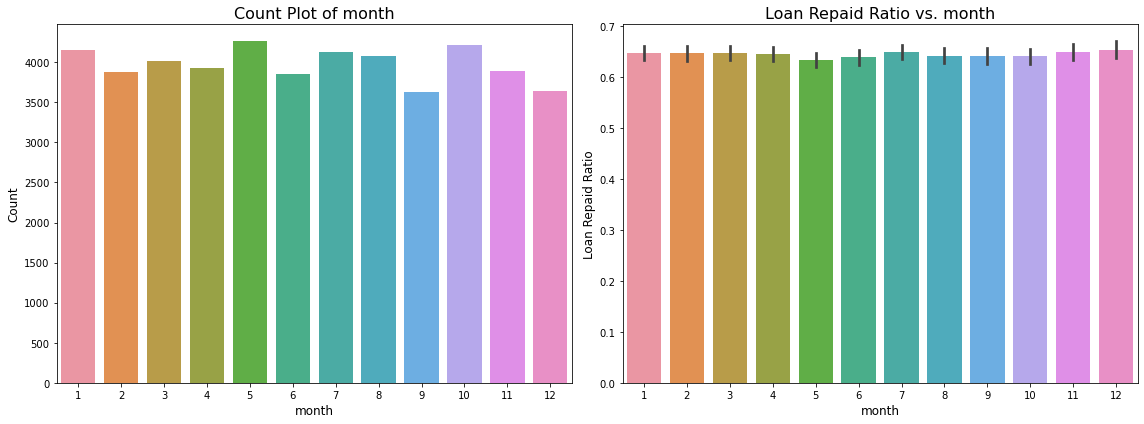

In [63]:
# visualization of 'month'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='month', data=data, ax=ax[0])
ax[0].set_xlabel('month', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of month', fontsize=16)

sns.barplot(x='month', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('month', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. month', fontsize=16)
plt.tight_layout()
plt.show()

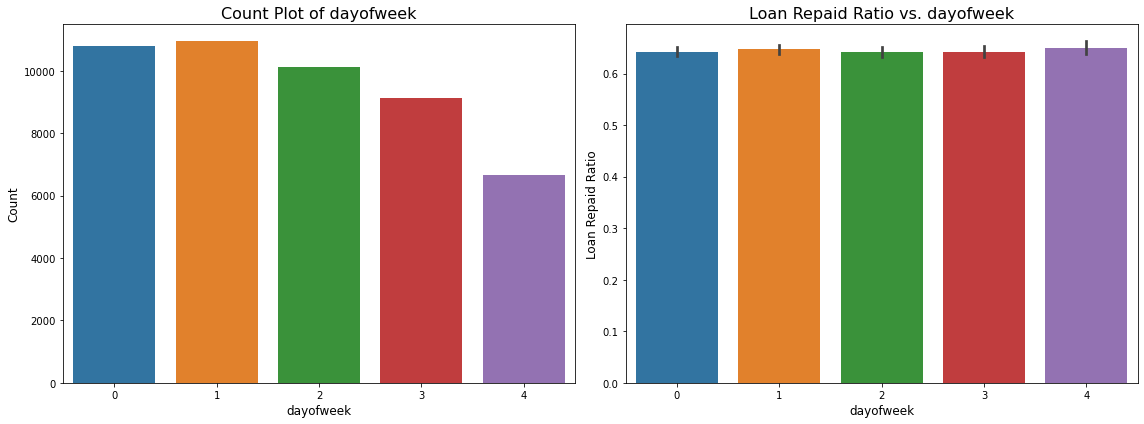

In [64]:
# visualization of 'dayofweek'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dayofweek', data=data, ax=ax[0])
ax[0].set_xlabel('dayofweek', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dayofweek', fontsize=16)

sns.barplot(x='dayofweek', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('dayofweek', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. dayofweek', fontsize=16)
plt.tight_layout()
plt.show()

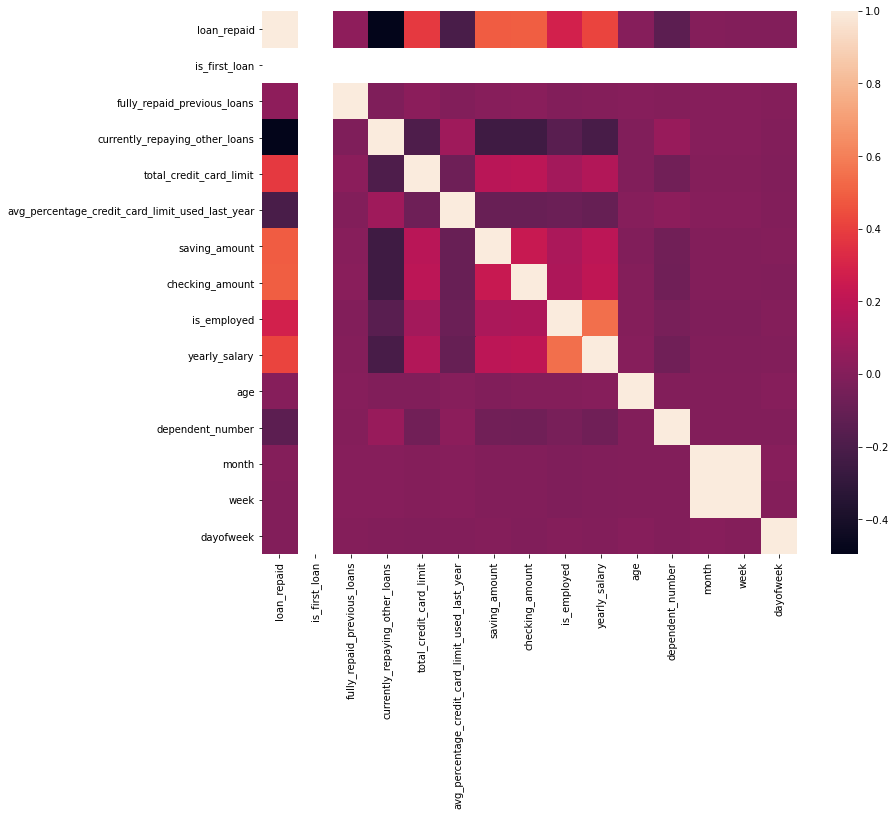

In [155]:
# feature correlation
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.dropna(axis=0, how='any').corr(), ax=ax)
plt.show()

# Feature Engineering

### 1. `fully_repaid_previous_loans` and `currently_repaying_other_loans`

In [277]:
# there is a clear connection between 'is_first_loan' and 'fully_repaid_previous_loans', 'currently_repaying_other_loans'
print(data[data['is_first_loan'] == 1]['fully_repaid_previous_loans'].unique())
print(data[data['is_first_loan'] == 1]['currently_repaying_other_loans'].unique())

[nan]
[nan]


In [278]:
# fill missing values with -1 for 'fully_repaid_previous_loans' and 'currently_repaying_other_loans'
data = data.fillna({'fully_repaid_previous_loans': -1, 'currently_repaying_other_loans': -1})

### 2. `avg_percentage_credit_card_limit_used_last_year`

In [279]:
# fill missing values with median
median = data['avg_percentage_credit_card_limit_used_last_year'].median()
data = data.fillna({'avg_percentage_credit_card_limit_used_last_year': median})

In [280]:
# drop useless features
data = data.drop(labels=['month', 'week', 'dayofweek'], axis=1, inplace=False)

In [281]:
# final data set for model building
data.head()

,loan_purpose,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,other,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,business,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4
6,business,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,emergency_funds,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,investment,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


In [285]:
# encoding 'loan_purpose'
encoder = LabelEncoder()
data['loan_purpose'] = encoder.fit_transform(data['loan_purpose'])
data

,loan_purpose,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,3,NaN,1,-1.0,-1.0,8600,0.79,1491,6285,1,45200,42,7
1,3,NaN,1,-1.0,-1.0,5300,0.52,141,5793,0,0,42,5
2,4,NaN,1,-1.0,-1.0,0,0.73,660,3232,1,26500,60,4
3,4,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,0,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101095,1,0.0,0,1.0,0.0,2400,0.40,553,2372,1,37000,56,3
101096,0,0.0,1,-1.0,-1.0,3100,0.68,367,1957,1,22700,59,5
101097,4,1.0,1,-1.0,-1.0,4600,0.50,1134,1621,1,35200,49,1
101098,0,1.0,0,1.0,0.0,6500,0.70,661,4333,1,19600,51,4


In [283]:
data.isnull().sum()

loan_purpose                                       0
loan_repaid                                        0
is_first_loan                                      0
fully_repaid_previous_loans                        0
currently_repaying_other_loans                     0
total_credit_card_limit                            0
avg_percentage_credit_card_limit_used_last_year    0
saving_amount                                      0
checking_amount                                    0
is_employed                                        0
yearly_salary                                      0
age                                                0
dependent_number                                   0
dtype: int64

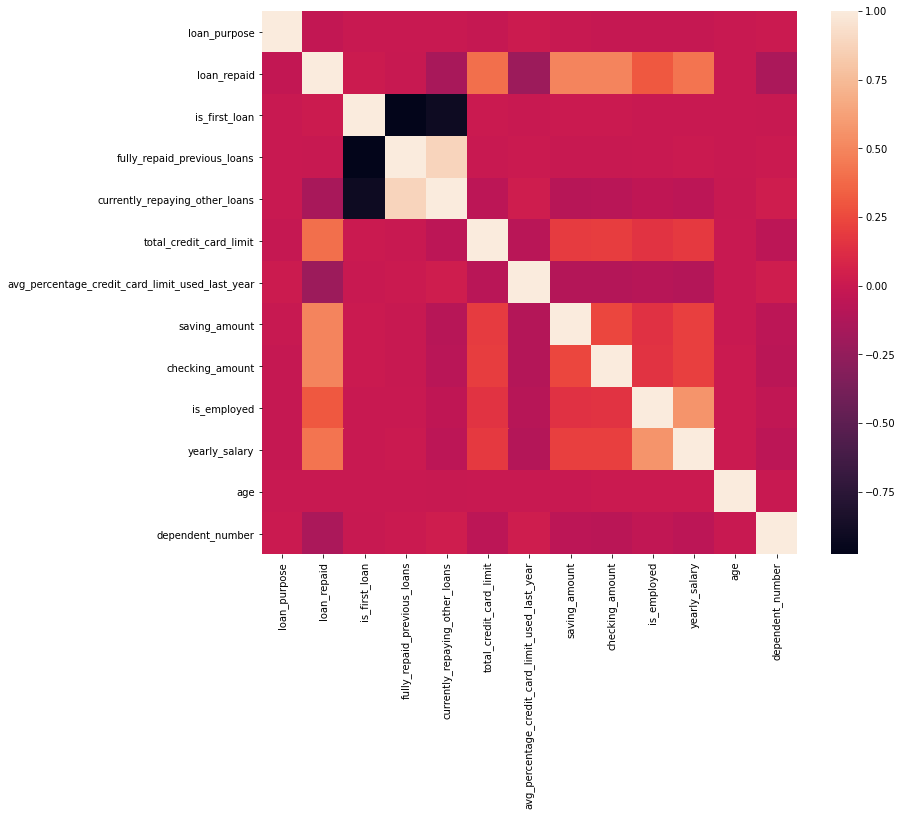

In [284]:
# feature correlation
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.corr(), ax=ax)
plt.show()

# Machine Learning

Here, I will try to implement the quite new package called LightGBM.

In [243]:
data.head()

,loan_purpose,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,month,week,dayofweek
3,other,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,6,26,2
4,business,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4,5,21,0
6,business,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2,3,11,2
7,emergency_funds,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2,8,35,4
8,investment,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1,5,21,4


In [245]:
# define categorical features
categorical_feature = ['loan_purpose', 'is_first_loan', 'fully_repaid_previous_loans', 
                       'currently_repaying_other_loans', 'is_employed']
target = 'loan_repaid'


In [261]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 16 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_purpose                                     101100 non-null  object 
 1   loan_repaid                                      47654 non-null   float64
 2   is_first_loan                                    101100 non-null  int64  
 3   fully_repaid_previous_loans                      101100 non-null  float64
 4   currently_repaying_other_loans                   101100 non-null  float64
 5   total_credit_card_limit                          101100 non-null  int64  
 6   avg_percentage_credit_card_limit_used_last_year  101100 non-null  float64
 7   saving_amount                                    101100 non-null  int64  
 8   checking_amount                                  101100 non-null  int64  
 9   is_employed    

In [262]:
# split into training and test data set
X = data.drop('loan_repaid', axis=1)
y = data['loan_repaid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [248]:
# create LightGBM dataset
d_train = lgb.Dataset(data=X_train, label=y_train, categorical_feature=categorical_feature, free_raw_data=False)

In [249]:
# Cross validation
params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': ['binary_logloss', 'auc'], 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 30, 
          'is_unbalance': True}

history = lgb.cv(params, train_set=d_train, num_boost_round=1000, nfold=5, 
                 early_stopping_rounds=20, seed=42, verbose_eval=False)

print('Best rounds:\t', len(history['auc-mean']))

Best rounds:	 103


In [297]:
# re-train the model and make predictions
clf = lgb.train(params, train_set=d_train, num_boost_round=767)
pred = clf.predict(X_test)

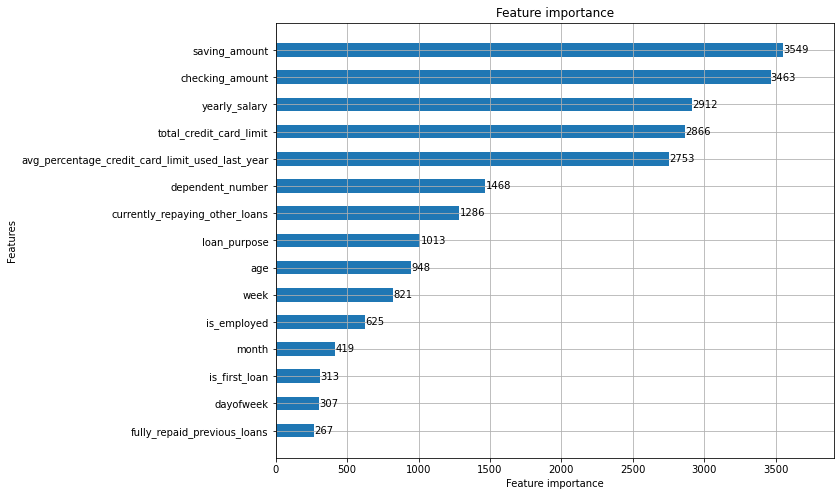

In [252]:
# feature importance
features = clf.feature_name()
importance = clf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 8))
lgb.plot_importance(clf, ax=ax, height=0.5)
plt.show()

# Questions

### Question 1

In [299]:
# Total profit from original bank:
loan_paid = y_test.astype(int).values
bank_profit = np.sum(loan_paid * 2 - 1)
print('Bank profit:\t', bank_profit)

Bank profit:	 3440


In [300]:
# Now, let's set a series of threshold to determine whether or not the loan will be given
def calculate_profit(loan_paid, probability, threshold):
    loan_granted = (probability > threshold).astype(int)
    profit = 0
    for i in range(len(loan_paid)):
        if loan_granted[i] == 1:
            if loan_paid[i] == 0:
                profit -= 1
            else:
                profit += 1
                
    return profit

In [301]:
# calculate the profit according to given threshold
thresholds = list(np.linspace(0, 1, 100))
profits = []

for threshold in thresholds:
    profits.append(calculate_profit(loan_paid, pred, threshold))

In [302]:
[bank_profit] 

[3440]

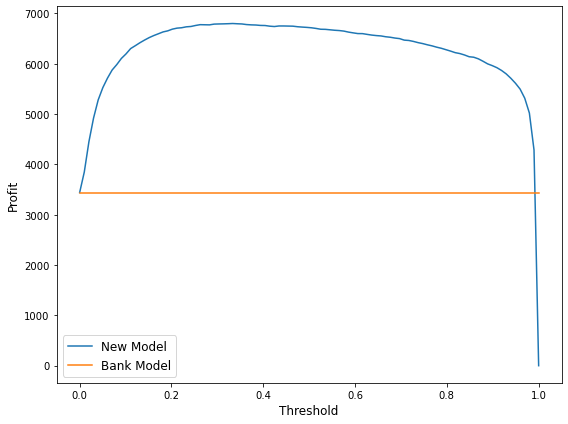

In [303]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, profits, label='New Model')
ax.plot(thresholds, [bank_profit] * len(thresholds), label='Bank Model')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Profit', fontsize=12)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [211]:
print("best_thresholds=%.2f" %thresholds[profits.index(max(profits))])
print("max_profits=%d" %max(profits))

best_thresholds=0.32
max_profits=6798


Clearly, the new model outperforms the original model used by the bank.

### Question 2

As discussed above

### Question 3

In my model, `saving_amount` and `checking_amount` are the top two most important features.

For the `is_employed`, it is not very important in my current model. However, `is_employed` is directly related to salary. For people with no employment, their salary is 0. Since salary is also very important, we can conclude that `is_employed` is also important, but it is indirectly related to the model.

[Reference Idea](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/12.LoanGrant/loan_grant.ipynb)

According to above plot, the most important feature is 'saving amount'. This makes perfect sense. Money in the saving account, meaure a person's ability to control his financial situation. More money in the saving account, more likely the borrower can repay.

As I mentioned, in my model, 'is_employed' is merged into feature 'salary', which correspond to the case 'salary=0'. according to above plot, salary is also a strong feature.

* if not employed, then salary=0, which will impact negatively on 'grant decision'. that is very easy to understand, a person without any financial input, will be very unlikely to repay.
* but even the person is employed, whether grant the loan or not, depends on his salary. higher salary indicates strong ability to repay.

### Question 4

Some useful feature which may include:

* Marriage status.
    - Because even a borrow cannot repay, if he/she is married, his/her spouse can help to repay.
* Housing status, has his/her own house, or rent appartments? if renting, how much is monthly rent?
    - Because even the borrower cannot repay, if he/she has house, the house can be sold to repay the debt
* Educational level
    - Normally a person who received higher education, has stronger capability to earn money to repay, and has higher moral standard to repay.